# 02 — Dimensional Geometry Lab

In this notebook, I take raw **pointer patterns** (drag gestures over time) and
turn them into **geometry-friendly signals**:

- Cube-style 3D rotation
- Sphere lat/lon motion
- Water-like surface offsets

This is the bridge between **user motion patterns** and the **dimensional UI hypercube**
engine from the main repo.


In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)

# 🔧 Point this to your Kaggle dataset slug
# Example: if dataset is peacebinflow/dimensional-ui-patterns,
# Kaggle mounts it at /kaggle/input/dimensional-ui-patterns
DATA_DIR = Path("/kaggle/input/dimensional-ui-patterns")

print("DATA_DIR:", DATA_DIR)
print("DATA_DIR exists:", DATA_DIR.exists())

pattern_files = []
if DATA_DIR.exists():
    pattern_files = list(DATA_DIR.rglob("*.json"))

print("JSON files found:", len(pattern_files))
for p in pattern_files:
    print(" -", p)


DATA_DIR: /kaggle/input/dimensional-ui-patterns
DATA_DIR exists: False
JSON files found: 0


In [2]:
rows = []

# Try to load real JSON pattern files first
if len(pattern_files) > 0:
    print("🔎 Loading real pattern files...")
    for file in pattern_files:
        try:
            with open(file, "r", encoding="utf-8") as f:
                raw = json.load(f)

            pid = raw.get("Id", "")
            user_id = raw.get("UserId")
            label = raw.get("Label", file.name)

            samples = raw.get("Samples", []) or raw.get("samples", [])

            for s in samples:
                rows.append(
                    {
                        "pattern_id": pid,
                        "user_id": user_id,
                        "label": label,
                        "x": s.get("X", s.get("x")),
                        "y": s.get("Y", s.get("y")),
                        "timestamp_ms": s.get("TimestampMs", s.get("timestamp_ms")),
                        "gesture_type": s.get("GestureType", s.get("gestureType")),
                        "shape_mode": s.get("ShapeMode", s.get("shapeMode")),
                        "theme": s.get("Theme", s.get("theme")),
                    }
                )
        except Exception as e:
            print("⚠ Error parsing", file, ":", e)

# If nothing loaded, fall back to dummy drag pattern
if len(rows) == 0:
    print("⚠ No real data found. Using dummy drag pattern instead.")

    for i in range(60):
        rows.append(
            {
                "pattern_id": "dummy_drag_01",
                "user_id": "demo_user",
                "label": "Dummy desert drag",
                "x": 100 + i * 4,
                "y": 200 + (i * (-2 if i % 2 == 0 else 2)),
                "timestamp_ms": 1700000000000 + i * 16,
                "gesture_type": 2,  # Drag
                "shape_mode": 0,    # Cube
                "theme": 0,         # Desert
            }
        )

df = pd.DataFrame(rows)
print("Rows loaded:", len(df))
print("Columns:", list(df.columns))
df.head()


⚠ No real data found. Using dummy drag pattern instead.
Rows loaded: 60
Columns: ['pattern_id', 'user_id', 'label', 'x', 'y', 'timestamp_ms', 'gesture_type', 'shape_mode', 'theme']


,pattern_id,user_id,label,x,y,timestamp_ms,gesture_type,shape_mode,theme
0,dummy_drag_01,demo_user,Dummy desert drag,100,200,1700000000000,2,0,0
1,dummy_drag_01,demo_user,Dummy desert drag,104,202,1700000000016,2,0,0
2,dummy_drag_01,demo_user,Dummy desert drag,108,196,1700000000032,2,0,0
3,dummy_drag_01,demo_user,Dummy desert drag,112,206,1700000000048,2,0,0
4,dummy_drag_01,demo_user,Dummy desert drag,116,192,1700000000064,2,0,0


In [3]:
# 2 = Drag (based on our enum plan)
DRAG_GESTURE = 2

drag_df = df[df["gesture_type"] == DRAG_GESTURE].copy()

print("Total drag samples:", len(drag_df))

if drag_df.empty:
    print("⚠ No drag samples found. The rest of the notebook will not show geometry.")
else:
    # Normalize time within each pattern
    drag_df["t_rel_ms"] = drag_df.groupby("pattern_id")["timestamp_ms"].transform(
        lambda col: col - col.min()
    )

drag_df.head()


Total drag samples: 60


,pattern_id,user_id,label,x,y,timestamp_ms,gesture_type,shape_mode,theme,t_rel_ms
0,dummy_drag_01,demo_user,Dummy desert drag,100,200,1700000000000,2,0,0,0
1,dummy_drag_01,demo_user,Dummy desert drag,104,202,1700000000016,2,0,0,16
2,dummy_drag_01,demo_user,Dummy desert drag,108,196,1700000000032,2,0,0,32
3,dummy_drag_01,demo_user,Dummy desert drag,112,206,1700000000048,2,0,0,48
4,dummy_drag_01,demo_user,Dummy desert drag,116,192,1700000000064,2,0,0,64


In [4]:
def simulate_cube_rotation(subset: pd.DataFrame, speed: float = 0.2) -> pd.DataFrame:
    """
    Roughly emulate cube rotation from drag:
    - Horizontal drag → rotate around vertical axis
    - Vertical drag → rotate around horizontal axis
    """
    subset = subset.sort_values("t_rel_ms").reset_index(drop=True)
    rotation_x = [0.0]
    rotation_y = [0.0]

    for i in range(1, len(subset)):
        dx = subset.loc[i, "x"] - subset.loc[i - 1, "x"]
        dy = subset.loc[i, "y"] - subset.loc[i - 1, "y"]

        new_y = rotation_y[-1] + (-dx) * speed   # invert x for left/right
        new_x = rotation_x[-1] + dy * speed      # up/down drag → rotate X

        rotation_x.append(new_x)
        rotation_y.append(new_y)

    out = subset.copy()
    out["cube_rot_x"] = rotation_x
    out["cube_rot_y"] = rotation_y
    return out


def simulate_sphere_rotation(subset: pd.DataFrame, speed: float = 0.15) -> pd.DataFrame:
    """
    Emulate lat/lon on a sphere from drag deltas.
    Clamp latitude to [-89, 89] to avoid pole flip weirdness.
    """
    subset = subset.sort_values("t_rel_ms").reset_index(drop=True)
    lat = [0.0]
    lon = [0.0]

    def clamp(v, vmin, vmax):
        return vmin if v < vmin else vmax if v > vmax else v

    for i in range(1, len(subset)):
        dx = subset.loc[i, "x"] - subset.loc[i - 1, "x"]
        dy = subset.loc[i, "y"] - subset.loc[i - 1, "y"]

        new_lon = lon[-1] + (-dx) * speed        # horizontal drag → longitude
        new_lat = clamp(lat[-1] + dy * speed, -89.0, 89.0)  # vertical drag → latitude

        lon.append(new_lon)
        lat.append(new_lat)

    out = subset.copy()
    out["sphere_lat"] = lat
    out["sphere_lon"] = lon
    return out


def simulate_water_offset(subset: pd.DataFrame, speed: float = 0.1) -> pd.DataFrame:
    """
    Emulate a wavy "water surface" offset from drag deltas.
    """
    subset = subset.sort_values("t_rel_ms").reset_index(drop=True)
    off_x = [0.0]
    off_y = [0.0]

    for i in range(1, len(subset)):
        dx = subset.loc[i, "x"] - subset.loc[i - 1, "x"]
        dy = subset.loc[i, "y"] - subset.loc[i - 1, "y"]

        new_x = off_x[-1] + (-dx) * speed
        new_y = off_y[-1] + (-dy) * speed

        off_x.append(new_x)
        off_y.append(new_y)

    out = subset.copy()
    out["water_off_x"] = off_x
    out["water_off_y"] = off_y
    return out


In [5]:
if drag_df.empty:
    print("⚠ No drag samples to simulate.")
else:
    # Just pick the first pattern id
    pid = drag_df["pattern_id"].iloc[0]
    one = drag_df[drag_df["pattern_id"] == pid].reset_index(drop=True)

    print("Using pattern:", pid)
    print("Label:", one["label"].iloc[0])

    cube_sim   = simulate_cube_rotation(one)
    sphere_sim = simulate_sphere_rotation(one)
    water_sim  = simulate_water_offset(one)

    cube_sim.head()


Using pattern: dummy_drag_01
Label: Dummy desert drag


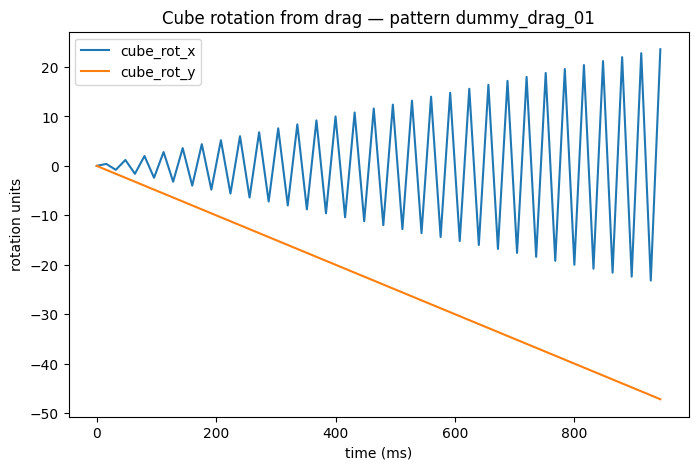

In [6]:
if not drag_df.empty:
    fig, ax = plt.subplots()
    ax.plot(cube_sim["t_rel_ms"], cube_sim["cube_rot_x"], label="cube_rot_x")
    ax.plot(cube_sim["t_rel_ms"], cube_sim["cube_rot_y"], label="cube_rot_y")
    ax.set_title(f"Cube rotation from drag — pattern {pid}")
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("rotation units")
    ax.legend()
    plt.show()
else:
    print("⚠ No drag samples to plot.")


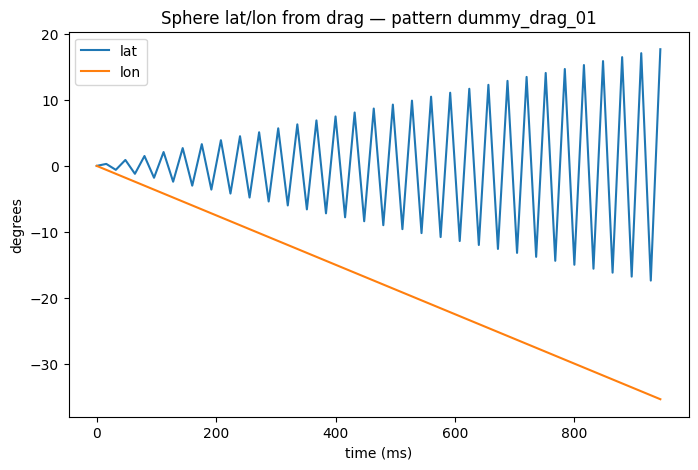

In [7]:
if not drag_df.empty:
    fig, ax = plt.subplots()
    ax.plot(sphere_sim["t_rel_ms"], sphere_sim["sphere_lat"], label="lat")
    ax.plot(sphere_sim["t_rel_ms"], sphere_sim["sphere_lon"], label="lon")
    ax.set_title(f"Sphere lat/lon from drag — pattern {pid}")
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("degrees")
    ax.legend()
    plt.show()
else:
    print("⚠ No drag samples to plot.")


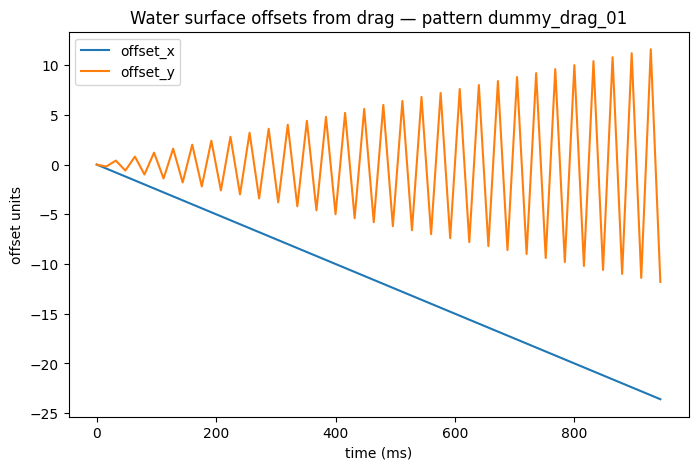

In [8]:
if not drag_df.empty:
    fig, ax = plt.subplots()
    ax.plot(water_sim["t_rel_ms"], water_sim["water_off_x"], label="offset_x")
    ax.plot(water_sim["t_rel_ms"], water_sim["water_off_y"], label="offset_y")
    ax.set_title(f"Water surface offsets from drag — pattern {pid}")
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("offset units")
    ax.legend()
    plt.show()
else:
    print("⚠ No drag samples to plot.")


## Summary

In this notebook, I:

- Took raw pointer drag samples (`x`, `y`, `timestamp_ms`)
- Filtered them into `drag_df`
- Transformed the motion into:
  - **Cube rotations** (`cube_rot_x`, `cube_rot_y`)
  - **Sphere positions** (`sphere_lat`, `sphere_lon`)
  - **Water surface offsets** (`water_off_x`, `water_off_y`)

These signals are the exact kind of geometry my **Dimensional UI Hypercube** engine
can feed into when rendering the interface in 3D / 4D-like space.

Next steps (in other notebooks):

- Use theme physics (Desert / Water / Neon) to change how these curves behave
- Connect this geometry to agent decisions (which theme, which mode, which depth)
v